# Linear Regression

## Agenda

1. [Bike Sharing Demand Dataset](#dataset)
    - 1.1 [Loading the data](#read)
    - 1.2 [Visualizing the data](#visualize) <br><br>
2. [Linear regression basics](#lrbasics)
    - 2.1 [Form of linear regression](#form)
    - 2.2 [Building a linear regression model](#build)
    - 2.3 [Using the model for prediction](#using)
    - 2.4 [Does the scale of the features matter?](#scale)  <br><br>
3. [Working with multiple features](#mfeatures)
    - 3.1 [Visualizing the data (part 2)](#viz2)
    - 3.2 [Adding more features to the model](#addfeatures)  <br><br>
4. [Choosing between models](#choosingmodel)
    - 4.1 [Feature selection](#featureselection)
    - 4.2 [Evaluation metrics for regression problems](#metrics)
    - 4.3 [Comparing models with train/test split and RMSE](#comparingRMSE)
    - 4.4 [Comparing testing RMSE with null RMSE](#testRMSE)  <br><br>
5. [Creating features](#creatingfeatures)
    - 5.1. [Handling categorical features](#catfeatures) 
    - 5.2. [Feature engineering](#featureengineering)    <br><br>
6. [Advantages/Disadvantages](#advantages)
7. [Regularization](#regularization)

<h1> 1. Bike Sharing Demand Dataset</h1>

<h2>Forecast use of a city bikeshare system</h2>
<p/>
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must <b>predict the <u>total count of bikes rented</u> during each hour</b> covered by the test set, using only information available prior to the rental period.
<p/>
<b>Data Fields</b>
<br/>
datetime - hourly date + timestamp<br/>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br/>
holiday - whether the day is considered a holiday<br/>
workingday - whether the day is neither a weekend nor holiday<br/>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br/>
temp - temperature in Celsius<br/>
atemp - "feels like" temperature in Celsius<br/>
humidity - relative humidity<br/>
windspeed - wind speed<br/>
casual - number of non-registered user rentals initiated<br/>
registered - number of registered user rentals initiated<br/>
count - number of total rentals<br/>

## 1.1. Loading the data <a id='read'>

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [1]:
# read the data and set the datetime as the index
import pandas as pd
url = 'https://raw.githubusercontent.com/upxacademy/ML_with_Python/master/Datasets/bikeshare.csv?token=AYxzdiGnjM610dBT7PuwUnUNOmm3bGcvks5ZFDyLwA%3D%3D'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [2]:

bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Questions:**

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?

In [3]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## 1.2. Visualizing the data  <a id='visualize'>

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

<AxesSubplot:xlabel='temp', ylabel='total'>

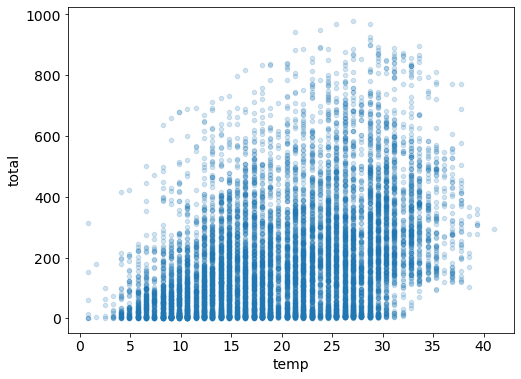

In [6]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2)

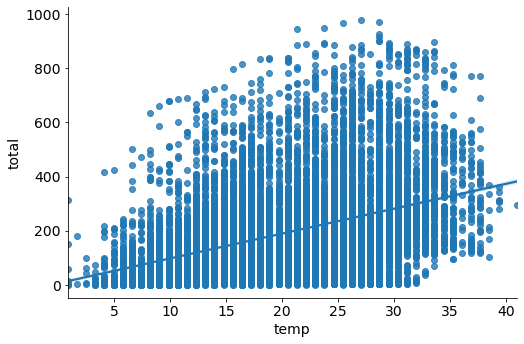

In [7]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.8})

<h1> 2. Linear Regression Basics  </h1>  <a id='lrbasics'>

## 2.1. Form of linear regression  <a id='form'>

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are going to find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

<img src="https://raw.githubusercontent.com/upxacademy/ML_with_Python/master/images/estimating_coefficients.png?token=AH0Y7JmsKZPG913jPp4rVGpOba5gxbonks5ZFEq7wA%3D%3D"></img>

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

## 2.2. Building a linear regression model  <a id='build'>

Refer : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [8]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total

In [9]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

In [10]:
# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

6.04621295961681
[9.17054048]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

## 2.3. Using the model for prediction  <a id='using'>
 
How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [11]:
# manually calculate the prediction
linreg.intercept_ + linreg.coef_*25

array([235.309725])

In [12]:
# use the predict method
linreg.predict(pd.DataFrame([25]))

array([235.309725])

## 2.4. Does the scale of the features matter?   <a id='scale'>

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [13]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


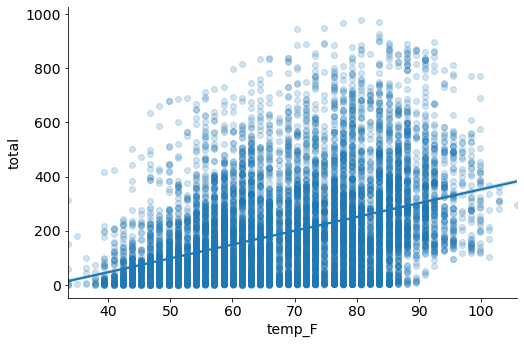

In [14]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

In [15]:
# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

-156.98561782129428
[5.09474471]


In [16]:
# convert 25 degrees Celsius to Fahrenheit
25 * 1.8 + 32

77.0

In [17]:
# predict rentals for 77 degrees Fahrenheit
linreg.predict(pd.DataFrame([77]))

array([235.309725])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [18]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

In [19]:
##have to bring it to uniform scale

<h1> 3. Working with multiple features  </h1>  <a id='mfeatures'>

## 3.1 Visualizing the data (part 2)  <a id='viz2'>

In [20]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

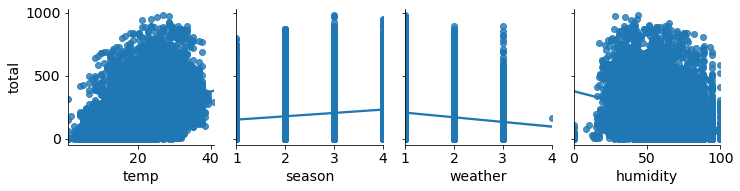

In [21]:
# multiple scatter plots in 

sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')

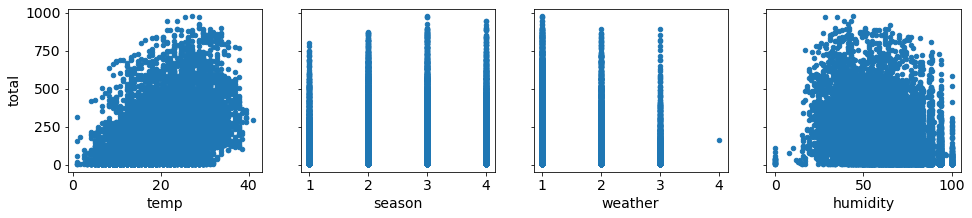

In [22]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are you seeing anything that you did not expect?

<AxesSubplot:title={'center':'total'}, xlabel='season'>

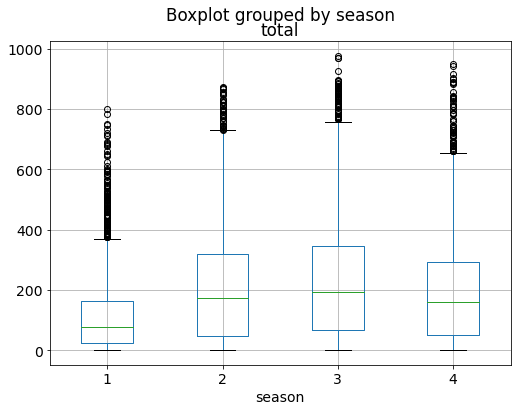

In [24]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season')

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter than in spring (?)

<AxesSubplot:xlabel='datetime'>

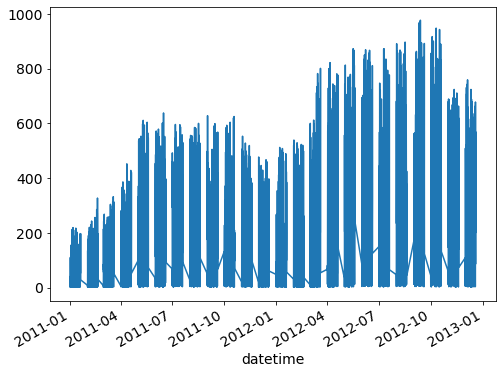

In [25]:
# line plot of rentals
bikes.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

## 3.2. Adding more features to the model   <a id='addfeatures'>

In [26]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [27]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

159.52068786129772
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


In [28]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('temp', 7.864824992477442),
 ('season', 22.53875753246678),
 ('weather', 6.670302035923743),
 ('humidity', -3.1188733823964956)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 7.86 bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase of 22.5 bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase of 6.67 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of 3.12 bikes**.

Does anything look incorrect?

<h1> 4. Choosing between models  </h1>   <a id='choosingmodel'>

## 4.1. Feature selection    <a id='featureselection'>   

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.



## 4.2. Evaluation metrics for regression problems   <a id='metrics'>

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [29]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [30]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(true, pred))
print ('MSE:', metrics.mean_squared_error(true, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [32]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print ('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before
print ('MSE:', metrics.mean_squared_error(true, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


## 4.3. Comparing models with train/test split and RMSE      <a id='comparingRMSE'>

In [37]:
from sklearn.model_selection import train_test_split

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [38]:
from sklearn.model_selection import train_test_split

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse_svm(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    svm = SVR(gamma='auto', C=1, kernel='linear',epsilon=0.0001)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [39]:
# compare different sets of features
print (train_test_rmse(['temp', 'season', 'weather', 'humidity']))
print (train_test_rmse(['temp', 'season', 'weather']))
print (train_test_rmse(['temp', 'season', 'humidity']))

155.64945913079674
164.1653997629182
155.59818936691417


In [40]:
# using these as features is not allowed!
print (train_test_rmse(['casual', 'registered']))

1.0315046973986794e-13


## 4.4. Comparing testing RMSE with null RMSE          <a id='testRMSE'>

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

- Actual - Prediction
 - 240   -    192
 - 130   -    192
 - 114    - 192

In [44]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([192.26451139, 192.26451139, 192.26451139, ..., 192.26451139,
       192.26451139, 192.26451139])

In [46]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

<h1> 5. Creating Features   </h1>   <a id='creatingfeatures'>

## 5.1. Handling categorical features  <a id='catfeatures'>

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [47]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**

In [48]:
# drop the first column
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [49]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0,0,1


In [50]:
# include dummy variables for season in the model
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
list(zip(feature_cols, linreg.coef_))

[('temp', 11.186405863575786),
 ('season_2', -3.3905430997179926),
 ('season_3', -41.73686071317081),
 ('season_4', 64.41596146824205),
 ('humidity', -2.819481636259649)]

How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [51]:
# compare original season variable with dummy variables
print (train_test_rmse(['temp', 'season', 'humidity']))
print (train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity']))

155.59818936691417
154.33394593636


## 5.2. Feature engineering     <a id='featureengineering'>

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

In [52]:
# hour as a numeric feature
bikes['hour'] = bikes.index.hour

In [53]:
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0,0,0,1


In [54]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([bikes, hour_dummies], axis=1)

In [55]:
# daytime as a categorical feature
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

In [56]:
bikes['daytime']

datetime
2011-01-01 00:00:00    0
2011-01-01 01:00:00    0
2011-01-01 02:00:00    0
2011-01-01 03:00:00    0
2011-01-01 04:00:00    0
                      ..
2012-12-19 19:00:00    1
2012-12-19 20:00:00    1
2012-12-19 21:00:00    0
2012-12-19 22:00:00    0
2012-12-19 23:00:00    0
Name: daytime, Length: 10886, dtype: int32

In [57]:
print (train_test_rmse(['hour']))
print (train_test_rmse(bikes.columns[bikes.columns.str.startswith('hour_')]))
print (train_test_rmse(['daytime']))

165.67174264111398
128.3112050281119
144.89116360237935


In [58]:
from sklearn.svm import SVR
print (train_test_rmse_svm(['hour']))
print (train_test_rmse_svm(bikes.columns[bikes.columns.str.startswith('hour_')]))
print (train_test_rmse_svm(['daytime']))

170.67311310114283
141.41210675133559
149.4061676749636


## 6. Advantages and Disdvantages   <a id='advantages'>

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions